In [17]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd
import os
import numpy as np
import json
import glob
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from matplotlib import rcParams
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


### Load data

In [18]:
# Load the data
df = pd.read_csv('../../regioes/dadosFinais.csv', sep=';')
# print(df.columns)
print(df['codLocation'].unique())

local = 1711115
df = df[df['codLocation'] == local]
df.head()

[1711105 1711107 1711110 1711111 1711115 1711116]


,Avaliacoes Total,Avaliacoes Apartamentos,Avaliacoes Moradias,Capital Divida Total,Capital Divida 3M,Capital Divida 6M,Capital Divida 12M,Juros Totais,Capital Amortizado,Unemployed population,...,Date,moving_avg_price_sell,exp_moving_avg_price_sell,price_to_rent_ratio,propriedades_unicas_rent,propriedades_unicas_sell,moving_avg_price_rent,exp_moving_avg_price_rent,moving_avg_Reducao_sell,moving_avg_Reducao_rent
1317,468,446,22.0,51817,97727,95476,94260.0,44,196,371.2,...,20180401,202955.666667,185891.371583,202.568216,0.0,3.0,1104.000000,993.847679,44.333333,7.0
1318,468,446,22.0,51817,97727,95476,94260.0,44,196,371.2,...,20180408,169080.000000,160455.685792,200.624071,9.0,-2.0,890.666667,833.423840,24.333333,3.0
1319,468,446,22.0,51817,97727,95476,94260.0,44,196,371.2,...,20180415,134624.333333,147097.842896,194.956268,-2.0,-2.0,675.333333,759.711920,1.000000,0.0
1320,468,446,22.0,51817,97727,95476,94260.0,44,196,371.2,...,20180422,134935.000000,141571.421448,205.506042,0.0,3.0,673.666667,710.855960,1.666667,0.0
1321,468,446,22.0,51817,97727,95476,94260.0,44,196,371.2,...,20180429,134707.000000,137953.710724,207.629057,0.0,-4.0,665.000000,678.927980,3.000000,0.0


In [19]:
# Separar variáveis independentes (X) e dependente (y)
X = df.drop(columns=['Preço médio_sell'])

# y = df[['Date','Preço médio_sell']]
y = df['Preço médio_sell'] # drop the m2

train_size = 0.7
test_size = 0.2
valid_size = 0.1

total_size = len(df)
train_end = int(train_size * total_size)
test_end = int((train_size + test_size) * total_size)

X_train = X.iloc[:train_end]
X_test = X.iloc[train_end:test_end]
X_valid = X.iloc[test_end:]

y_train = y.iloc[:train_end]
y_test = y.iloc[train_end:test_end]
y_valid = y.iloc[test_end:]


print(f"Tamanho do conjunto de treinamento: {len(X_train)}")
print(f"Tamanho do conjunto de teste: {len(X_test)}")
print(f"Tamanho do conjunto de validação: {len(X_valid)}")

# Preparar dados para treino
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Tamanho do conjunto de treinamento: 231
Tamanho do conjunto de teste: 66
Tamanho do conjunto de validação: 34


### Train the model

In [20]:
# Seach for the best parameters

param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False]
}


linear_model = LinearRegression()
grid_search = GridSearchCV(estimator=linear_model, 
                           param_grid=param_grid, 
                           cv=5,  # número de folds na validação cruzada
                           scoring='neg_mean_absolute_error'  #'r2', #neg_mean_absolute_error',  # Métrica usada para avaliação
                        #    n_jobs=-1  # Usar todos os núcleos disponíveis
                        #    error_score=np.nan,  # Valor a ser atribuído em caso de erro
                          )

grid_search.fit(X_train, y_train)

best_linear_model = grid_search.best_estimator_
best_linear_param = grid_search.best_params_

print("Best Linear Model:", best_linear_model)
print("Best Linear Param:", best_linear_param)

Best Linear Model: LinearRegression(fit_intercept=False)
Best Linear Param: {'copy_X': True, 'fit_intercept': False}


### Metrics

In [21]:
def calcular_metricas(y_real, y_pred, conjunto):
    mae = mean_absolute_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)
    mse = mean_squared_error(y_real, y_pred)
    acuracia = (1 - (mae / np.mean(y_real))) * 100
    print(f"{conjunto}: MAE: {mae:.2f}, R²: {r2:.2f}, MSE: {mse:.2f}, Acurácia: {acuracia:.2f}%")
    return mae, r2, mse, acuracia

In [22]:
from sklearn.model_selection import TimeSeriesSplit

print("\nAvaliação sem TimeSeriesSplit:")
y_train_pred = best_linear_model.predict(X_train)
y_test_pred = best_linear_model.predict(X_test)

mae_train, r2_train, mse_train, acc_train = calcular_metricas(y_train, y_train_pred, "Treino")
mae_test, r2_test, mse_test, acc_test = calcular_metricas(y_test, y_test_pred, "Teste")


print("\nAvaliação com TimeSeriesSplit:")
tscv = TimeSeriesSplit(n_splits=5)

for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train_tscv, X_test_tscv = X.iloc[train_index], X.iloc[test_index]
    y_train_tscv, y_test_tscv = y.iloc[train_index], y.iloc[test_index]
    
    best_linear_model.fit(X_train_tscv, y_train_tscv)
    y_pred_tscvtrain = best_linear_model.predict(X_train_tscv)
    y_pred_tscvtest = best_linear_model.predict(X_test_tscv)

    mae_testTrain, r2_testTrain, mse_testTrain, acc_testTrain = calcular_metricas(y_train_tscv, 
                                                              y_pred_tscvtrain, 
                                                              f"TimeSeries Split {i+1}")
    
    mae_testT, r2_testT, mse_testT, acc_testT = calcular_metricas(y_test_tscv, 
                                                              y_pred_tscvtest, 
                                                              f"TimeSeries Split {i+1}")


Avaliação sem TimeSeriesSplit:
Treino: MAE: 3215.85, R²: 0.96, MSE: 14945874.04, Acurácia: 98.16%
Teste: MAE: 59152.62, R²: -156.47, MSE: 4435166683.77, Acurácia: 72.60%

Avaliação com TimeSeriesSplit:
TimeSeries Split 1: MAE: 116.46, R²: 1.00, MSE: 19853.34, Acurácia: 99.92%
TimeSeries Split 1: MAE: 3831.57, R²: -4.29, MSE: 25541891.24, Acurácia: 97.77%
TimeSeries Split 2: MAE: 126.49, R²: 1.00, MSE: 29596.04, Acurácia: 99.92%
TimeSeries Split 2: MAE: 80008535.59, R²: -1275338399.71, MSE: 8533186572944991.00, Acurácia: -45305.67%
TimeSeries Split 3: MAE: 108.77, R²: 1.00, MSE: 23799.30, Acurácia: 99.93%
TimeSeries Split 3: MAE: 2774.46, R²: 0.90, MSE: 9385179.13, Acurácia: 98.57%
TimeSeries Split 4: MAE: 140.02, R²: 1.00, MSE: 35423.65, Acurácia: 99.92%
TimeSeries Split 4: MAE: 10051.44, R²: -5.19, MSE: 133682157.34, Acurácia: 95.31%
TimeSeries Split 5: MAE: 213.07, R²: 1.00, MSE: 77070.24, Acurácia: 99.88%
TimeSeries Split 5: MAE: 3117.86, R²: 0.60, MSE: 13695927.37, Acurácia: 98.62

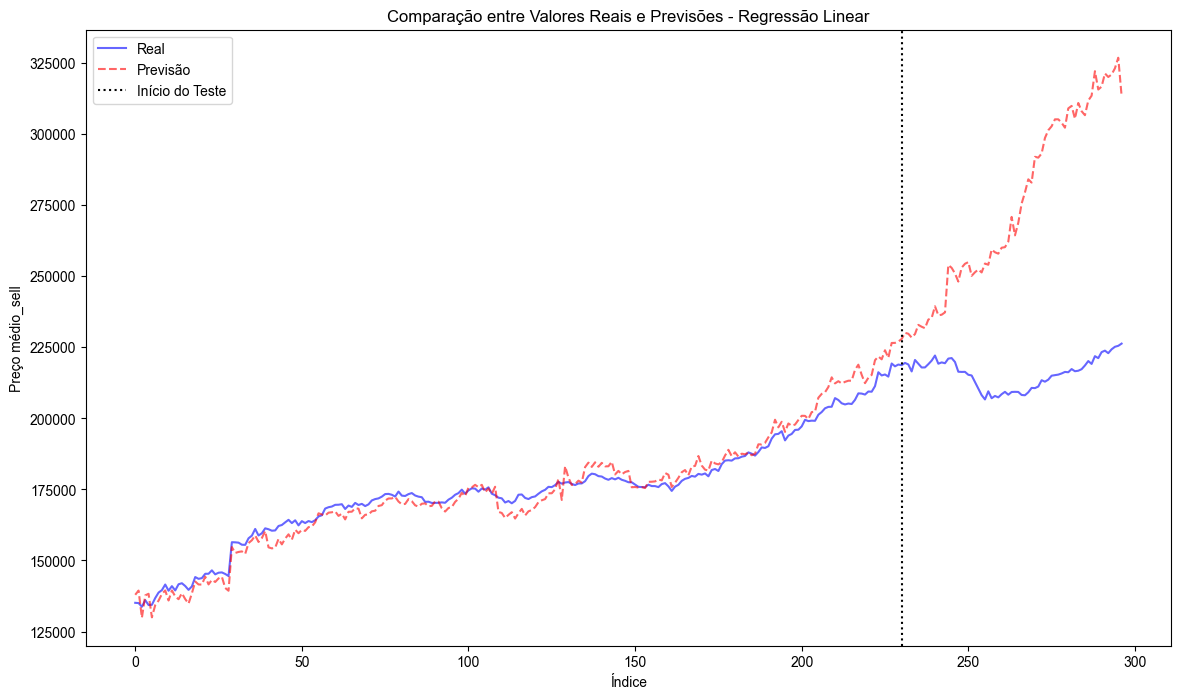

In [25]:
rcParams['font.family'] = 'Arial'

indices = np.concatenate([np.arange(len(y_train)), np.arange(len(y_train), len(y_train) + len(y_test))])
y_real = np.concatenate([y_train, y_test])
y_pred = np.concatenate([y_train_pred, y_test_pred])


plt.figure(figsize=(14, 8))
plt.plot(indices, y_real, color='blue', label='Real', alpha=0.6)
plt.plot(indices, y_pred, color='red', label='Previsão', linestyle='--', alpha=0.6)
plt.axvline(x=len(y_train) - 1, color='black', linestyle=':', label='Início do Teste')

plt.title('Comparação entre Valores Reais e Previsões - Regressão Linear')
plt.xlabel('Índice')
plt.ylabel('Preço médio_sell')
plt.legend()
plt.show()

C:\Users\ruben\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128 (\x80) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


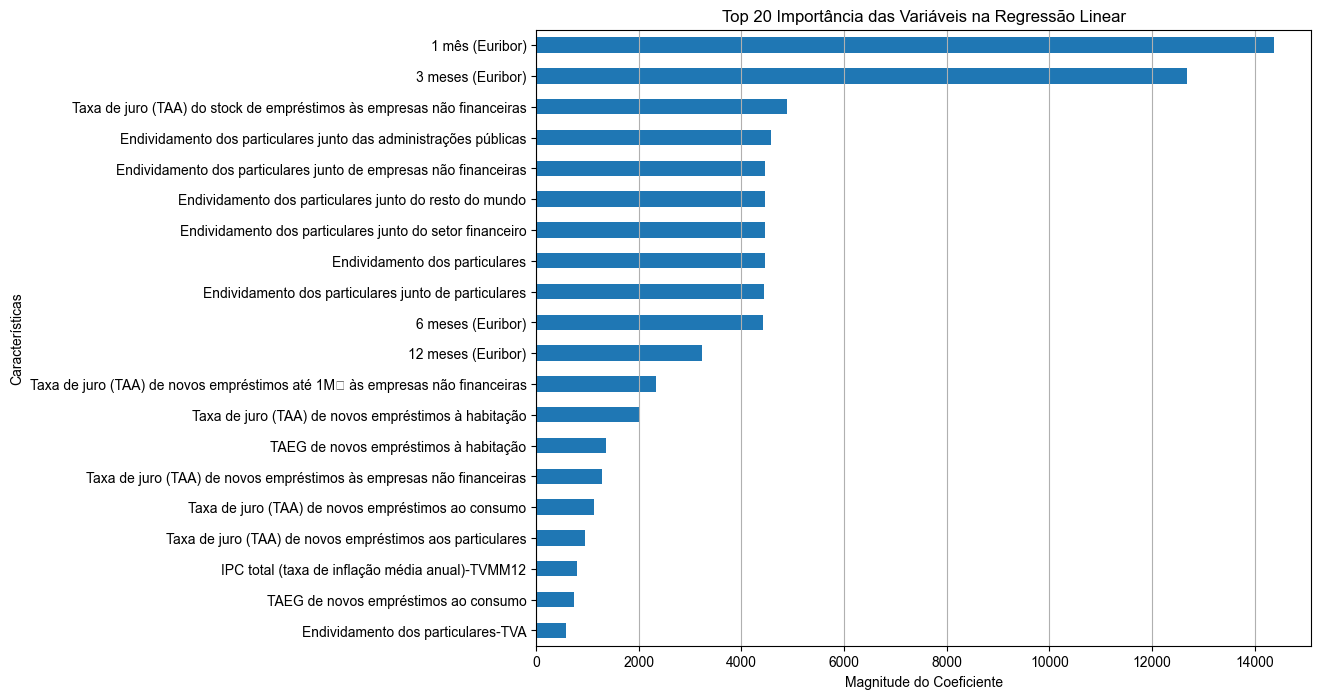

In [26]:
coefficients = best_linear_model.coef_
original_feature_names = X.columns
feature_importances_linear = pd.Series(coefficients, index=original_feature_names)
feature_importances_linear = feature_importances_linear.abs().sort_values(ascending=False)

top_20_features = feature_importances_linear.head(20)

plt.figure(figsize=(10, 8))
top_20_features.plot(kind='barh', title='Top 20 Importância das Variáveis na Regressão Linear')
plt.xlabel('Magnitude do Coeficiente')
plt.ylabel('Características')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

#### Dados de validacao

In [10]:
y_valid_pred = best_linear_model.predict(X_valid)

mae_valid, r2_valid, mse_valid, acc_valid = calcular_metricas(y_valid, 
                                                              y_valid_pred, 
                                                              "Validação")

Validação: MAE: 3005.50, R²: 0.07, MSE: 13605808.12, Acurácia: 98.69%


Validação: MAE: 3005.50, R²: 0.07, MSE: 13605808.12, Acurácia: 98.69%


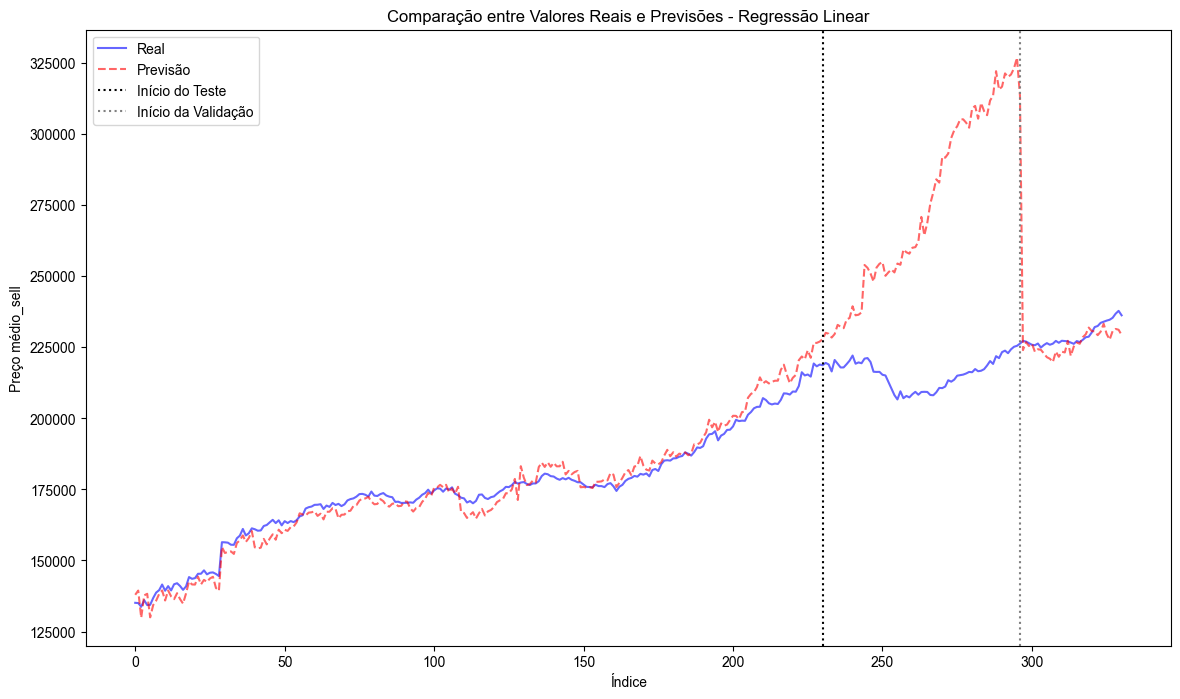

In [11]:

rcParams['font.family'] = 'Arial'
y_valid_pred = best_linear_model.predict(X_valid)
mae_valid, r2_valid, mse_valid, acc_valid = calcular_metricas(y_valid, y_valid_pred, "Validação")


indices = np.concatenate([np.arange(len(y_train)), 
                          np.arange(len(y_train), len(y_train) + len(y_test)), 
                          np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_valid))])

y_real = np.concatenate([y_train, y_test, y_valid])
y_pred = np.concatenate([y_train_pred, y_test_pred, y_valid_pred])


plt.figure(figsize=(14, 8))
plt.plot(indices, y_real, color='blue', label='Real', alpha=0.6)
plt.plot(indices, y_pred, color='red', label='Previsão', linestyle='--', alpha=0.6)

plt.axvline(x=len(y_train) - 1, color='black', linestyle=':', label='Início do Teste')
plt.axvline(x=len(y_train) + len(y_test) - 1, color='gray', linestyle=':', label='Início da Validação')

plt.title('Comparação entre Valores Reais e Previsões - Regressão Linear')
plt.xlabel('Índice')
plt.ylabel('Preço médio_sell')
plt.legend()

plt.show()


In [12]:
tscv_valid = TimeSeriesSplit(n_splits=5)
y_valid_real = []
y_valid_pred_tscv = []

for i, (train_index, test_index) in enumerate(tscv_valid.split(X_valid)):
    X_train_valid, X_test_valid = X_valid.iloc[train_index], X_valid.iloc[test_index]
    y_train_valid, y_test_valid = y.iloc[train_index], y.iloc[test_index]
    
    best_linear_model.fit(X_train_valid, y_train_valid)
    y_pred_valid_split = best_linear_model.predict(X_test_valid)
    
    y_valid_real.append(y_test_valid)
    y_valid_pred_tscv.append(y_pred_valid_split)


    mae_valid_split, r2_valid_split, mse_valid_split, acc_valid_split = calcular_metricas(
        y_test_valid, y_pred_valid_split, f"TimeSeries Split Validação {i+1}"
    )

y_valid_real_concat = np.concatenate(y_valid_real)
y_valid_pred_concat = np.concatenate(y_valid_pred_tscv)

mae_validT, r2_validT, mse_validT, acc_validT = calcular_metricas(y_valid_real_concat, 
                                                              y_valid_pred_concat, 
                                                              "Validação Final")


TimeSeries Split Validação 1: MAE: 3499.80, R²: -15.06, MSE: 15878758.51, Acurácia: 97.51%
TimeSeries Split Validação 2: MAE: 3793.22, R²: -8.59, MSE: 21794607.72, Acurácia: 97.32%
TimeSeries Split Validação 3: MAE: 5507.21, R²: -35.61, MSE: 44408402.50, Acurácia: 96.20%
TimeSeries Split Validação 4: MAE: 3291.16, R²: -67.15, MSE: 14052350.09, Acurácia: 97.73%
TimeSeries Split Validação 5: MAE: 187932.33, R²: -310284.81, MSE: 52859992345.88, Acurácia: -20.45%
Validação Final: MAE: 40804.75, R²: -339.41, MSE: 10591225292.94, Acurácia: 71.99%


### Results

In [13]:
results = { 
    'Conjunto': ['Treino', 'Teste', 'Validação', 'TimeSeries Split', 'TimeSeries Split Validação'],
    'MAE': [mae_train, mae_test, mae_valid, mae_testT, mae_validT],
    'R²': [r2_train, r2_test, r2_valid, r2_testT, r2_validT],
    'MSE': [mse_train, mse_test, mse_valid, mse_testT, mse_validT],
    'Acurácia (%)': [acc_train, acc_test, acc_valid, acc_testT, acc_validT]
}

results_df = pd.DataFrame(results)

results_df.head(10)

,Conjunto,MAE,R²,MSE,Acurácia (%)
0,Treino,3215.849015,0.957727,1.494587e+07,98.159929
1,Teste,59152.622861,-156.468443,4.435167e+09,72.598612
2,Validação,3005.501336,0.065201,1.360581e+07,98.688688
3,TimeSeries Split,3117.859915,0.600666,1.369593e+07,98.618399
4,TimeSeries Split Validação,40804.745249,-339.406335,1.059123e+10,71.989468


In [14]:
import os
import json

def salvar_resultados_modelo(modelo_nome, localizacao,resultados_df):
    # Criar estrutura para salvar
    results_dict = resultados_df.to_dict(orient='records')
    results_dict_with_model = {
        "Modelo": modelo_nome,
        "Localização": localizacao,
        "Resultados": results_dict
    }

    # Caminho do diretório e do arquivo JSON
    directory = "modelos"
    json_filename = os.path.join(directory, 'resultadosModelos.json')

    # Criar o diretório se não existir
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Verificar se o arquivo já existe
    if os.path.exists(json_filename):
        with open(json_filename, 'r') as json_file:
            existing_data = json.load(json_file)
    else:
        existing_data = []

    # Adicionar os novos resultados
    existing_data.append(results_dict_with_model)

    # Salvar de volta no arquivo JSON
    with open(json_filename, 'w') as json_file:
        json.dump(existing_data, json_file, indent=4)

    print(f"Dados salvos e adicionados ao arquivo {json_filename}")


salvar_resultados_modelo("Linear Regression", local, results_df)


Dados salvos e adicionados ao arquivo modelos\resultadosModelos.json
